In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

In [2]:
import awkward as ak
import pandas as pd
import sys
import os

weaver_core_path = os.path.abspath("../weaver-core/weaver")
sys.path.insert(0, weaver_core_path)

# Now import the required modules
from utils.dataset import _finalize_inputs, DataConfig

# File paths
parquet_file = '/n/holystore01/LABS/iaifi_lab/Lab/nswood/TopLandscape/test_file.parquet'
config_file = 'data/TopLandscape/top_kin.yaml'

# Load data from Parquet file
df = pd.read_parquet(parquet_file).head(100000)



In [3]:
jet_pt, jet_eta, jet_label = df['jet_pt'], df['jet_eta'],df['label']


In [4]:
# # Convert DataFrame to a list of dictionaries
# records = df.to_dict('records')

# # Create the Awkward Array
# ak_array = ak.from_iter(records)


# # Load data configuration
# data_config = DataConfig.load(config_file)
# from utils.dataset import _preprocess, DataConfig

# # Define options for preprocessing
# options = {
#     'training': False,        # True for training, False for testing
#     'shuffle': False,         # Shuffle the data
#     'reweight': False,       # Reweighting is optional
#     'up_sample': True,       # Upsample if necessary
#     'weight_scale': 1,       # Weight scaling factor
#     'max_resample': 10,      # Maximum resampling iterations
# }

# processed_data, indices = _preprocess(ak_array, data_config, options)
# pf_data = processed_data['_pf_features'].transpose(0,2,1)
# pf_mask = processed_data['_pf_mask'].transpose(0,2,1)
# cur_data = pf_data[0]
# cur_mask = pf_mask[0,:,0].astype(bool)
# cur_data= cur_data[cur_mask]

In [5]:
import uproot
def read_root_file(file_path):
    with uproot.open(file_path) as file:
        # Assuming the tree name is the first key in the file
        tree = file[file.keys()[0]]
        # Convert the tree to an awkward array
        data = tree.arrays(library='ak')
    # Convert the awkward array to an Arrow table, then to a Pandas DataFrame
    arrow_table = ak.to_arrow_table(data)
    return arrow_table.to_pandas()

In [10]:
# (R,R)
# test_path = '/n/holystore01/LABS/iaifi_lab/Lab/nswood/training/TopLandscape/PMTrans/20241220-131744_example_PMTransformer_e2e271107d6c1f08b0a8cc7a12c8ef5c_r_adam_lr0.0005_batch128PMTrans_R_128_R_96_partD128_jetD96_layers8_nheads4_redo_2/predict_output/pred.root'

# (RxH, RxH)
# test_path = '/n/holystore01/LABS/iaifi_lab/Lab/nswood/training/TopLandscape/PMTrans/20241205-061806_example_PMTransformer_34572cf6ff96687d980a950698050b91_r_adam_lr0.0005_batch128PMTrans_RxH_4_RxH_4_partD8_jetD8_layers1_nheads1_redo_3_smaller/predict_output/pred.root'

test_path = '/n/holystore01/LABS/iaifi_lab/Lab/nswood/training/TopLandscape/PMTrans/20241204-091131_example_PMTransformer_172e121a4ff253da198432f47d79306d_r_adam_lr0.0005_batch128PMTrans_RxH_80_RxH_64_partD160_jetD128_layers8_nheads8_redo_3/predict_output/pred.root'


df = read_root_file(test_path)

In [11]:
gromov_data = pd.read_csv('top_gromov_delta_results.csv')#.head(100)
# gromov_data = pd.read_csv("top_EMD_gromov_delta_results.csv")#.head(100)


qcd_jets = df[df['jet_isQCD']]
top_jets = df[df['jet_isTop']]
common_indices = top_jets.index.intersection(gromov_data.index)

# Assign the filtered gromov_data to the new column
top_jets = top_jets.loc[common_indices]
top_jets['gromov_d'] = gromov_data['rel_delta'].loc[common_indices]

common_indices = qcd_jets.index.intersection(gromov_data.index)

# Assign the filtered gromov_data to the new column
qcd_jets = qcd_jets.loc[common_indices]
qcd_jets['gromov_d'] = gromov_data['rel_delta'].loc[common_indices]


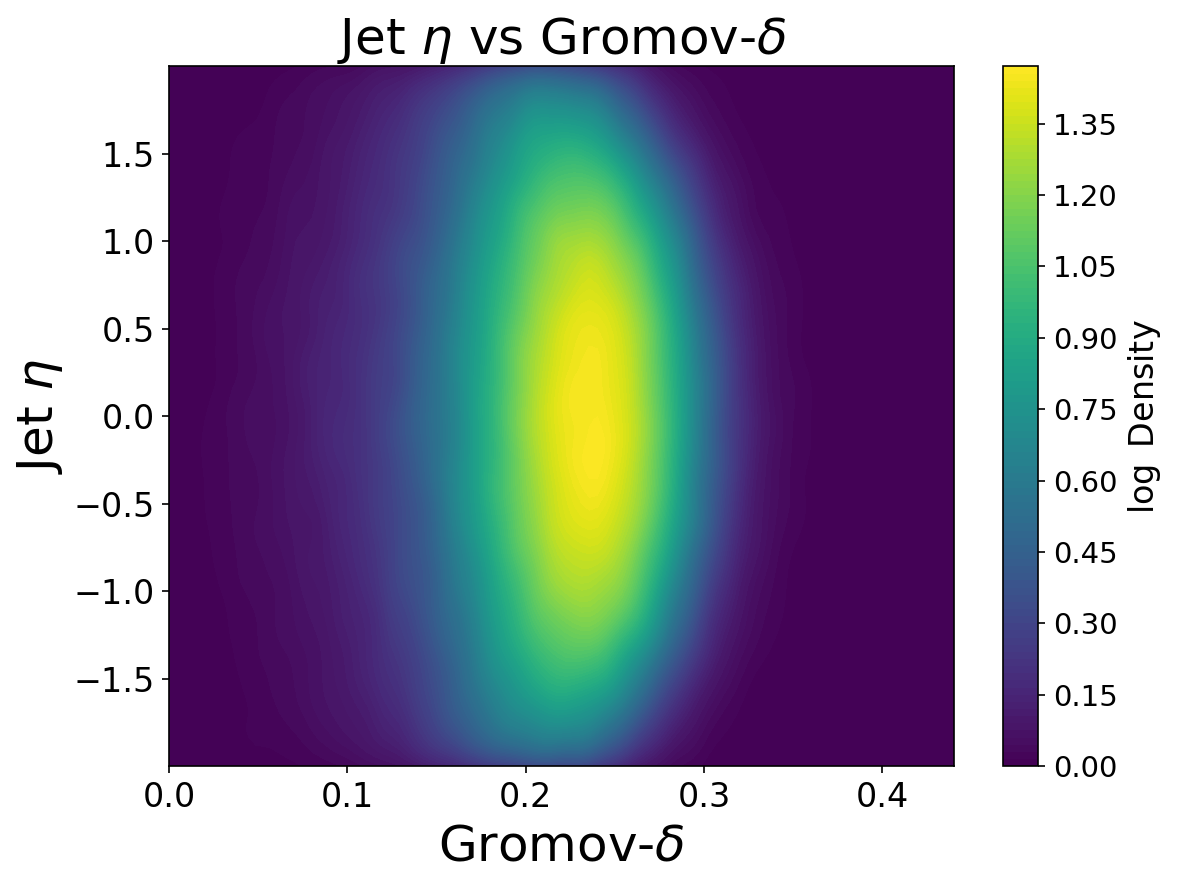

In [12]:
rel_delta = gromov_data['rel_delta']
jet_pt = gromov_data['jet_eta']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
jet_pt = jet_pt[mask]

x = rel_delta
y = jet_pt

# Define grid points for smooth heatmap
x_grid = np.linspace(x.min(), x.max(), 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')

colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)

# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Jet $\\eta$', fontsize=24)
plt.title(f'Jet $\\eta$ vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()
# Labels

In [ ]:
rel_delta = gromov_data['rel_delta']
jet_pt = gromov_data['jet_pt']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
jet_pt = jet_pt[mask]

x = rel_delta
y = jet_pt

# Define grid points for smooth heatmap
x_grid = np.linspace(x.min(), x.max(), 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')

colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)


# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Jet $p_T$', fontsize=24)
plt.title(f'Jet $p_T$ vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()
# Labels

KeyboardInterrupt: 

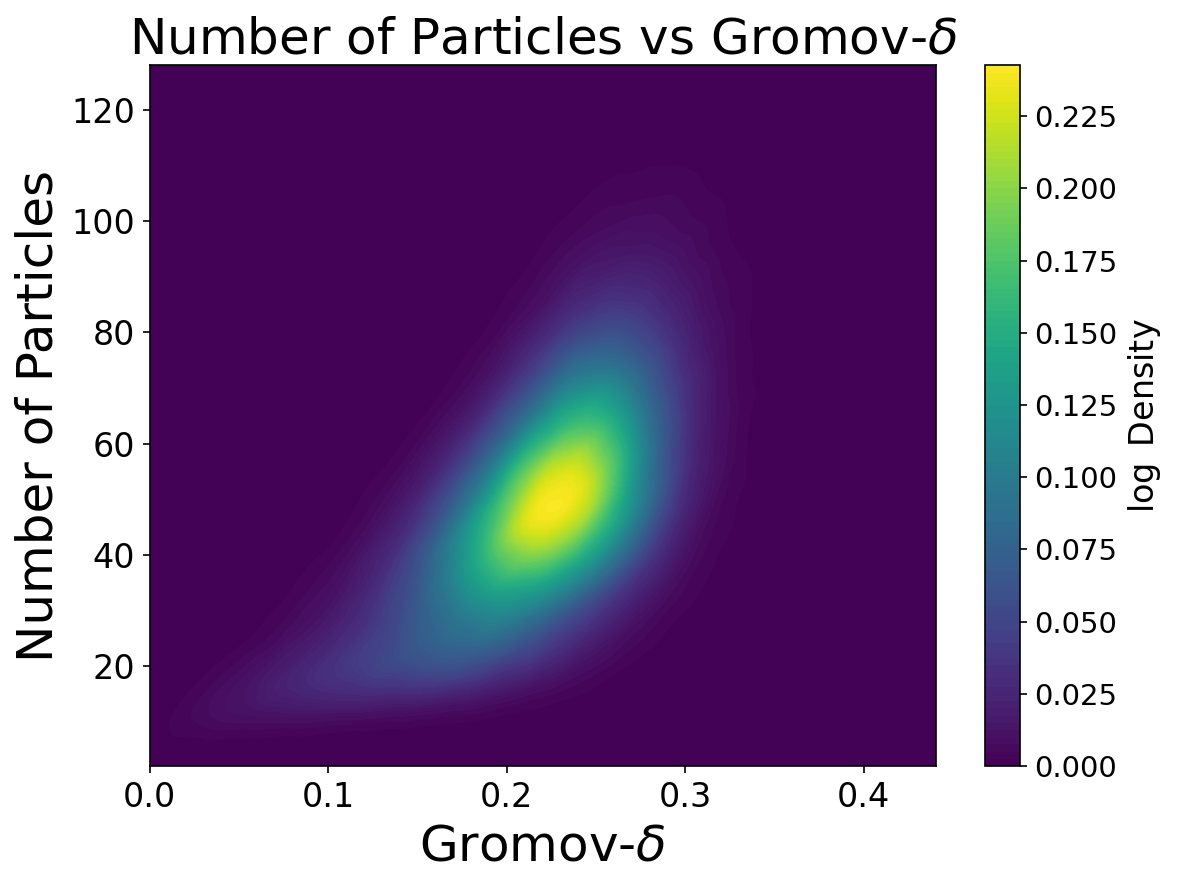

In [414]:


# Assuming rel_delta and jet_pt are defined
rel_delta = gromov_data['rel_delta']
jet_pt = gromov_data['jet_nparts']

# Remove NaN values
mask = ~np.isnan(rel_delta)
rel_delta = rel_delta[mask]
jet_pt = jet_pt[mask]

# Create a 2D grid for KDE
x = rel_delta
y = jet_pt

# Define grid points for smooth heatmap
x_grid = np.linspace(x.min(), x.max(), 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')
colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)

# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Number of Particles', fontsize=24)
plt.title(f'Number of Particles vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()


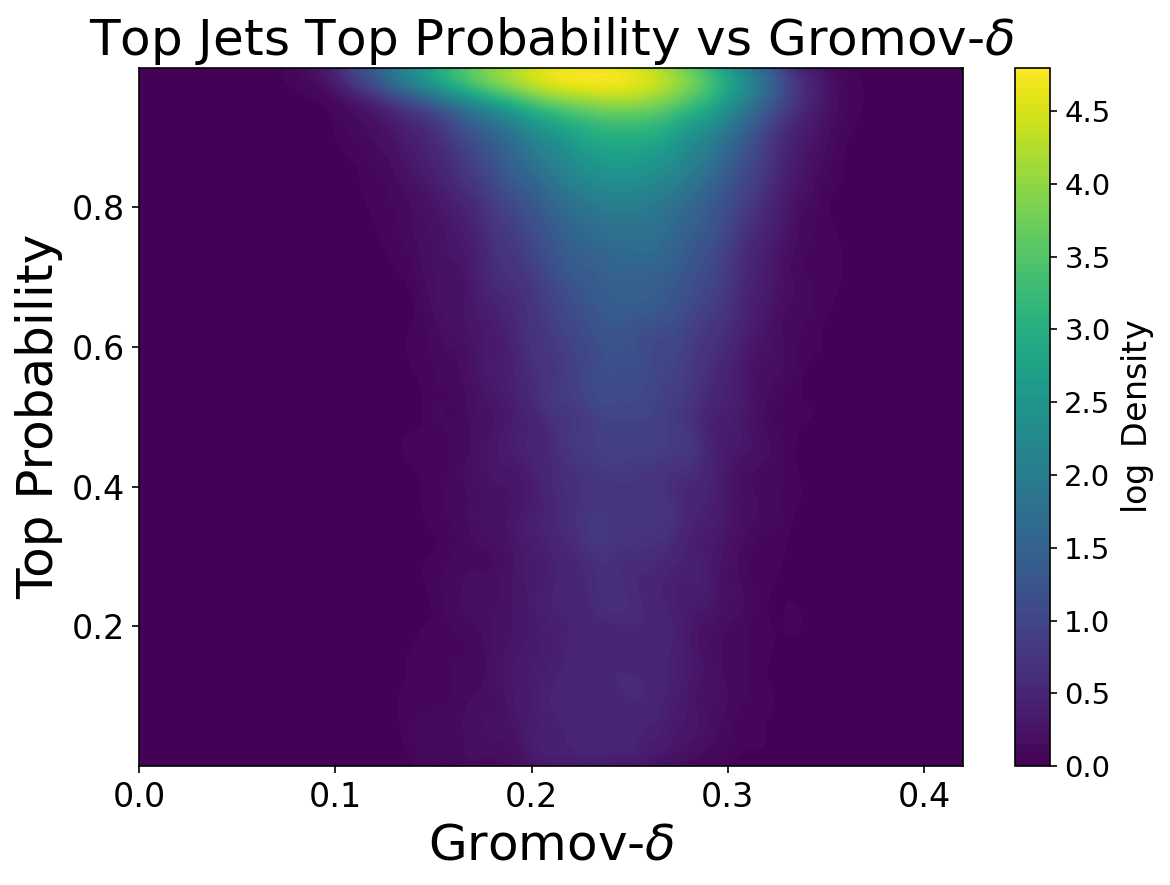

In [13]:
rel_delta = top_jets['gromov_d']
top_pred = top_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

# Create a 2D grid for KDE
x = rel_delta
y = top_pred

# Define grid points for smooth heatmap
x_grid = np.linspace(0, 0.42, 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))
z = np.log1p(z) 
# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')
colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)

# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Top Probability', fontsize=24)
plt.title(f'Top Jets Top Probability vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()


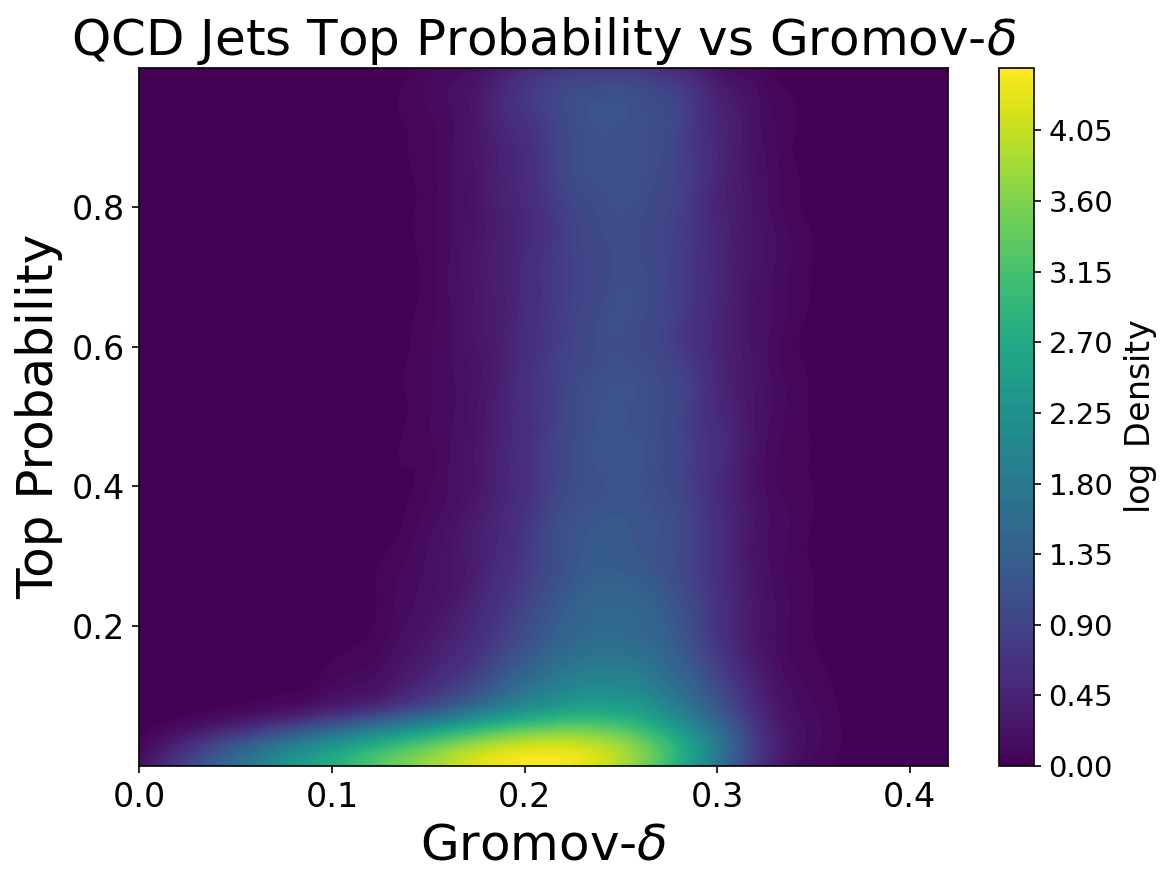

In [14]:
rel_delta = qcd_jets['gromov_d']
top_pred = qcd_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

# Create a 2D grid for KDE
x = rel_delta
y = top_pred

# Define grid points for smooth heatmap
x_grid = np.linspace(0, 0.42, 100)
y_grid = np.linspace(y.min(), y.max(), 100)
x_mesh, y_mesh = np.meshgrid(x_grid, y_grid)

# Perform KDE
kde = gaussian_kde([x, y])
z = kde(np.vstack([x_mesh.ravel(), y_mesh.ravel()]))

z = np.log1p(z) 

# Reshape the KDE output for plotting
z = z.reshape(x_mesh.shape)

# Plot the smooth heatmap
fig = plt.figure(figsize=(8, 6),dpi=150)
fig.patch.set_facecolor('white')
plt.contourf(x_mesh, y_mesh, z, levels=100, cmap='viridis')
colorbar =plt.colorbar(label='Density')
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label(f'$\log$ Density', size=16)  
ax = plt.gca()
ax.tick_params(axis='x', which='major', labelsize=16)
ax.tick_params(axis='y', which='major', labelsize=16)
# Labels and title
plt.xlabel(f'Gromov-$\\delta$', fontsize=24)
plt.ylabel(f'Top Probability', fontsize=24)
plt.title(f'QCD Jets Top Probability vs Gromov-$\\delta$', fontsize=24)

plt.tight_layout()
plt.show()


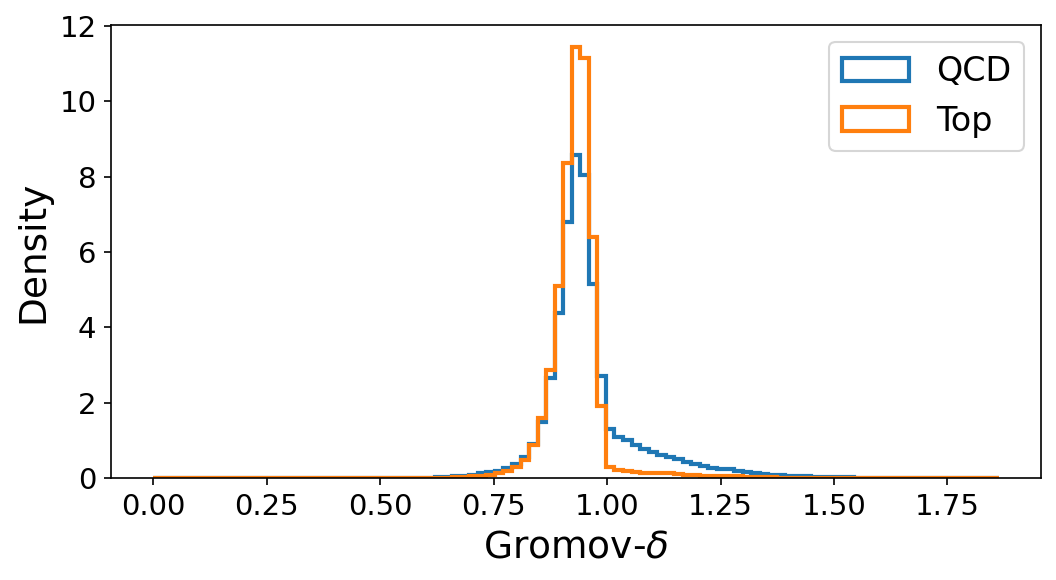

In [8]:

top_jets_gromov_d = top_jets['gromov_d']
qcd_jets_gromov_d = qcd_jets['gromov_d']

# Define common bins
bins = np.linspace(min(top_jets_gromov_d.min(), qcd_jets_gromov_d.min()),
                   max(top_jets_gromov_d.max(), qcd_jets_gromov_d.max()), 100)

# Plot the histograms
fig = plt.figure(figsize=(8, 4), dpi=150)
plt.hist(top_jets_gromov_d, bins=bins, histtype='step', label='QCD',density = True,linewidth=2)
plt.hist(qcd_jets_gromov_d, bins=bins, histtype='step', label='Top',density = True,linewidth=2)

# Add labels and legend
plt.legend(fontsize = 16)
plt.xlabel(r'Gromov-$\delta$', fontsize=18)
plt.ylabel('Density', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=14)

# Set figure background color
fig.patch.set_facecolor('white')

# Show the plot
plt.show()


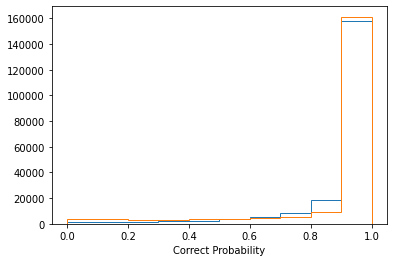

In [15]:
plt.hist(top_jets['score_jet_isTop'],histtype = 'step',label = 'QCD')
plt.hist(qcd_jets['score_jet_isQCD'],histtype = 'step',label = 'Top')
plt.xlabel('Correct Probability')
plt.show()


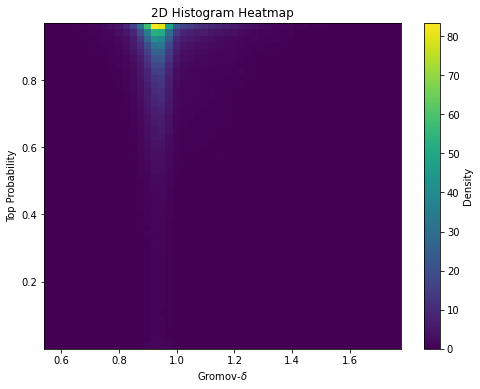

In [10]:
rel_delta = top_jets['gromov_d']
top_pred = top_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

# Create a 2D histogram
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges, im = plt.hist2d(rel_delta, top_pred, bins=50, cmap='viridis', density=True)

# Add a colorbar
plt.colorbar(im, label='Density')

# Labels
plt.xlabel(f'Gromov-$\\delta$')
plt.ylabel(f'Top Probability')
plt.title('2D Histogram Heatmap')

plt.show()


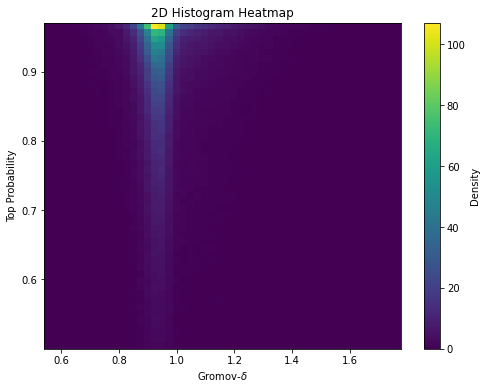

In [11]:
rel_delta = top_jets['gromov_d']
top_pred = top_jets['score_jet_isTop']

mask = ~np.isnan(rel_delta)

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

mask = top_pred > 0.5

rel_delta = rel_delta[mask]
top_pred = top_pred[mask]

## how to normalize this by gromov_data['rel_delta'] in the x direction.


# Create a 2D histogram
plt.figure(figsize=(8, 6))
heatmap, xedges, yedges, im = plt.hist2d(rel_delta, top_pred, bins=50, cmap='viridis', density=True)

# Add a colorbar
plt.colorbar(im, label='Density')

# Labels
plt.xlabel(f'Gromov-$\\delta$')
plt.ylabel(f'Top Probability')
plt.title('2D Histogram Heatmap')

plt.show()

In [84]:
import numpy as np 
percentiles = [50, 75, 90, 95, 99]

# Calculate percentiles
percentile_values = np.percentile(, percentiles)
cur_mask = curvatures

In [93]:
percentiles = [50, 75, 90, 95, 99]

curvatures = gromov_data['c'].to_numpy()

percentile_values = np.percentile(curvatures, percentiles)

cur_mask = (~np.isnan(curvatures)) & (curvatures > percentile_values[0])

In [95]:
cur_mask.astype(int)

array([0, 0, 0, ..., 0, 0, 0])

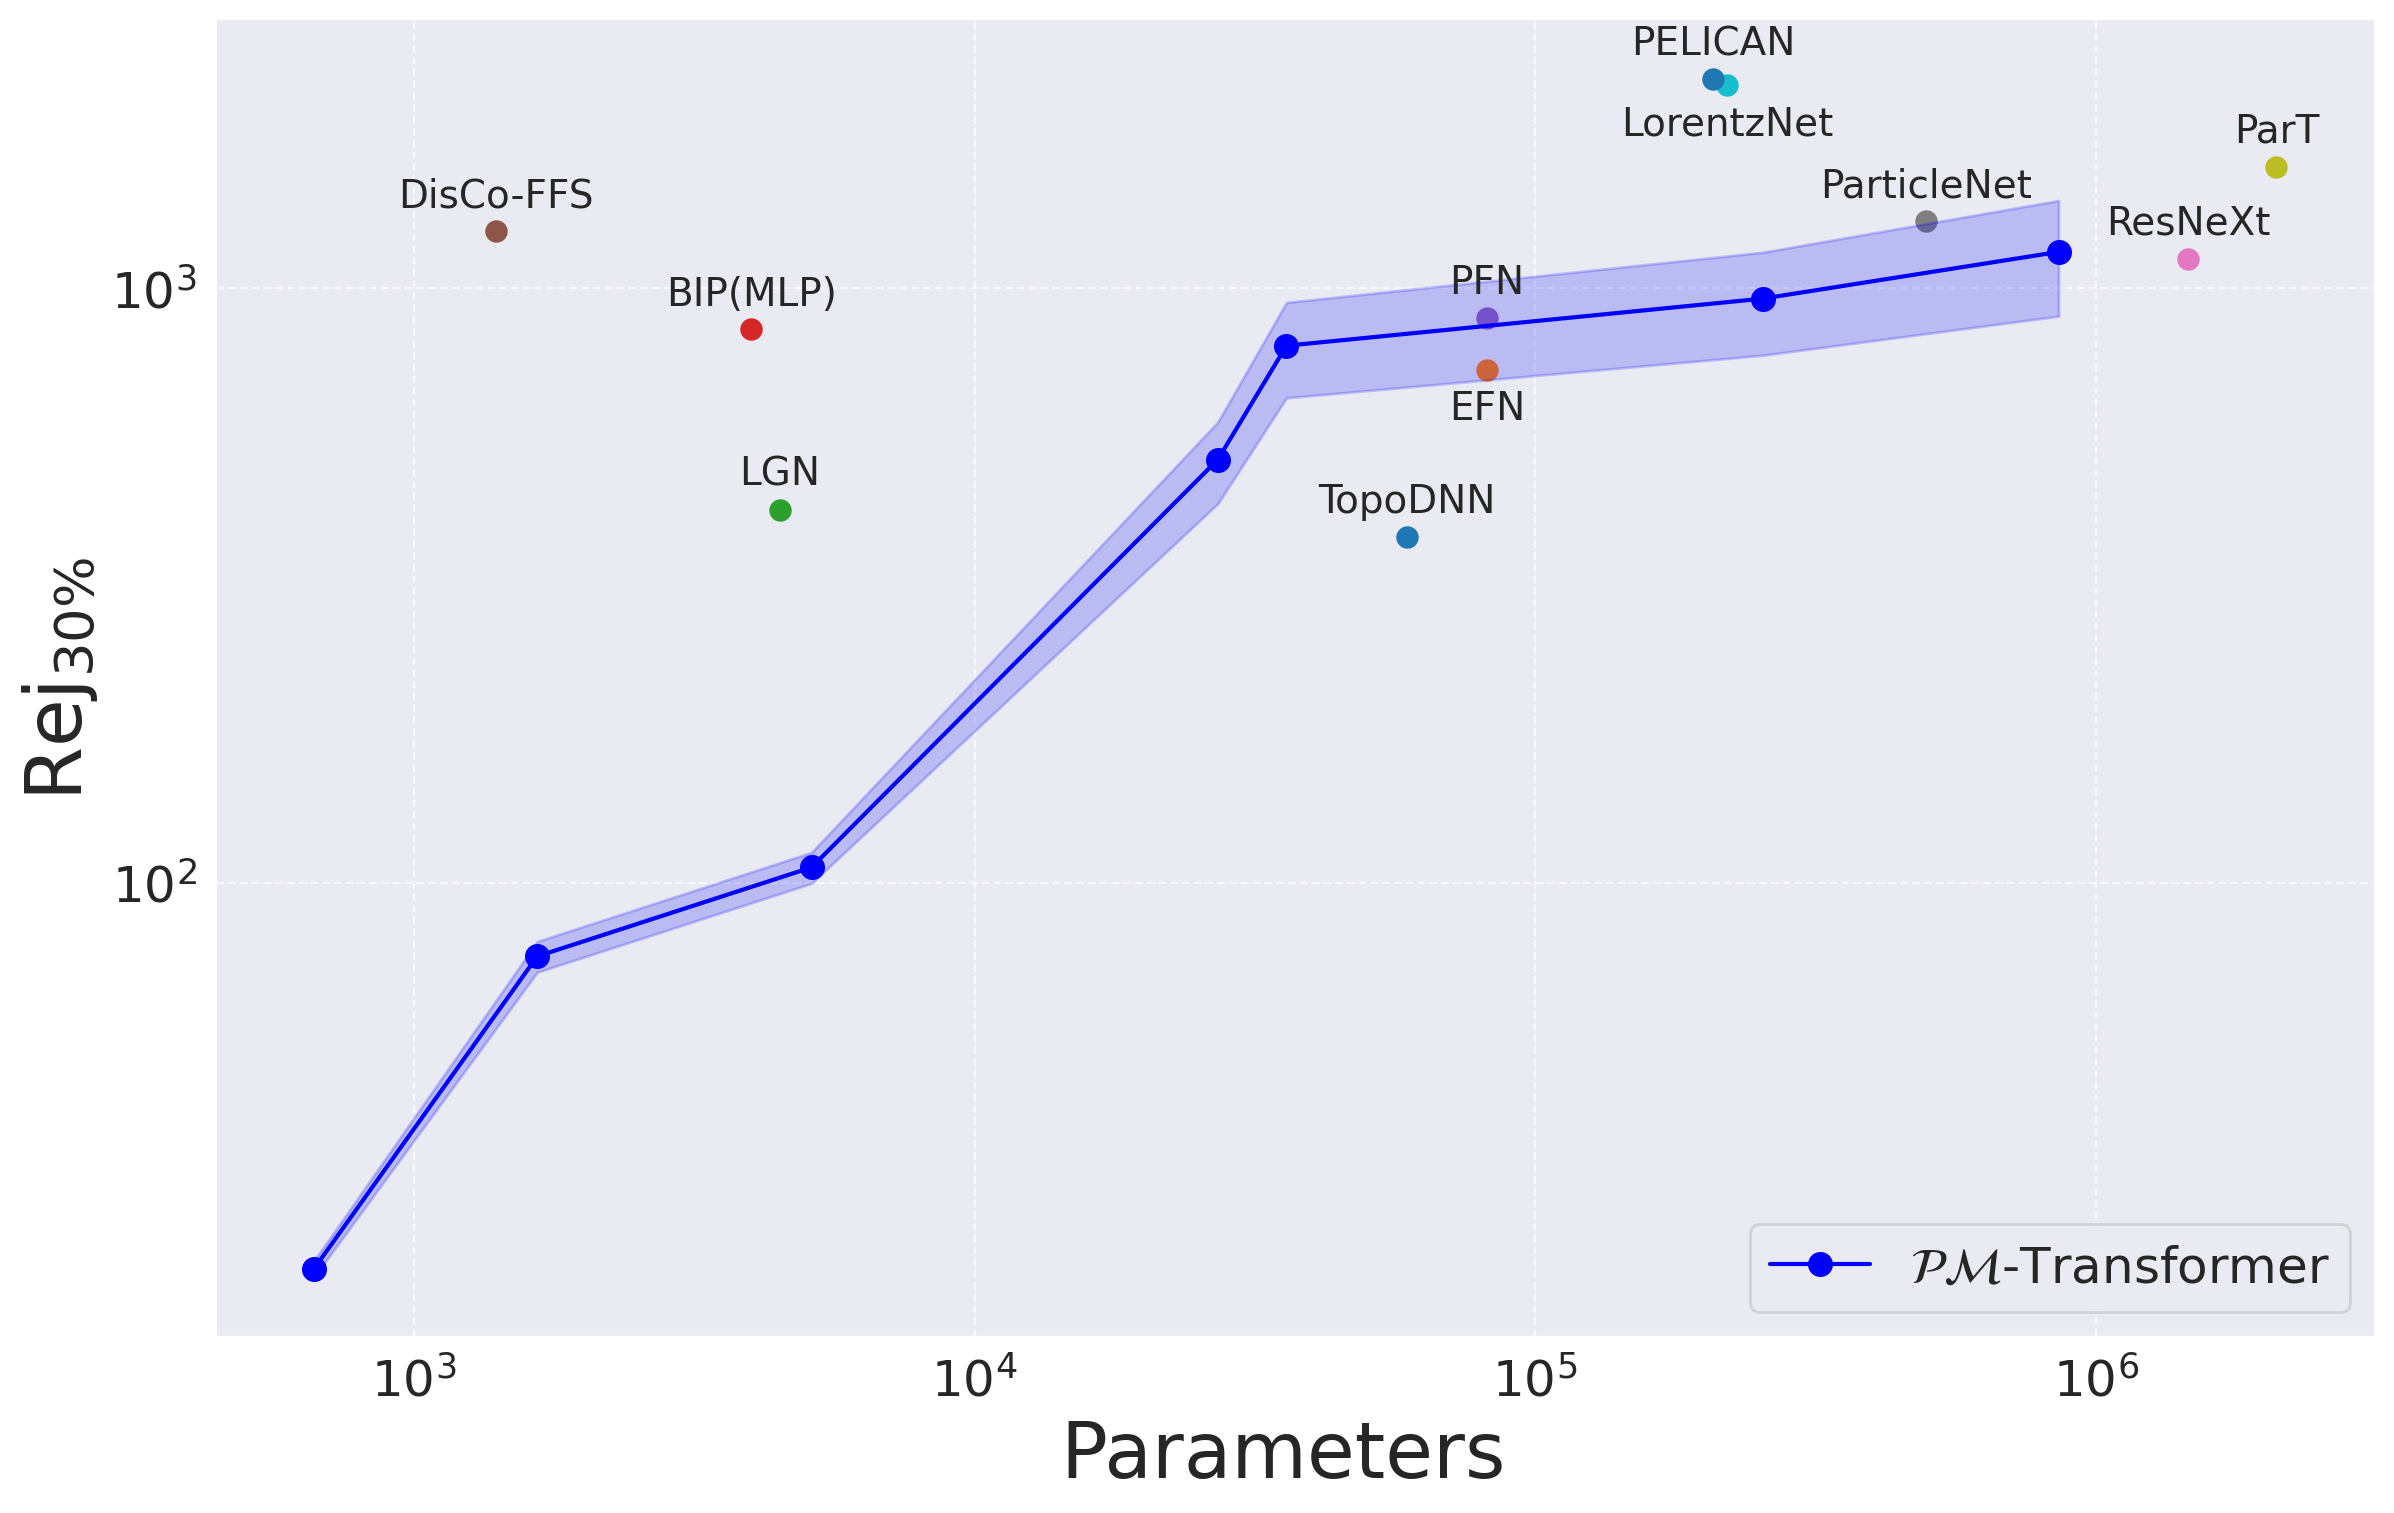

      params  overall_auc  accuracy_mean  overall_accuracy  accuracy_std  \
18     664.0     0.908910       0.861867          0.862156      0.001676   
10    1660.0     0.951785       0.899170          0.899128      0.001402   
9     5120.0     0.958407       0.903413          0.903520      0.001503   
5    27160.0     0.978248       0.926500          0.926507      0.001348   
7    36010.0     0.981249       0.930892          0.931064      0.001074   
19  254550.0     0.982586       0.934186          0.934178      0.001165   
28  858190.0     0.984272       0.937554          0.937700      0.001086   

    Top_rejection_50_mean  Top_rejection_50_std  Top_rejection_50_full  \
18              13.480469              0.291116              13.470812   
10              34.219623              1.336649              33.872505   
9               43.569433              1.742347              43.469107   
5              157.726561             12.725387             159.489731   
7              217.80

In [15]:

# warnings.filterwarnings('ignore')
#

# Load the DataFrame
results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)

results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]

split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1,2,3,4,7,8]]
results_df[['particle_geom', 'particle_dim','jet_geom','jet_dim','layers','heads']] = split_columns
results_df['layers'] = results_df['layers'].str[-1]
results_df['heads'] = results_df['heads'].str.split('nheads').str[1]


param_map = {'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
  'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
  'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
  'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
  'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
  'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
  'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
  'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
  'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
  'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
  'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0} 

# Group by the columns and select the rows with the maximum 'overall_accuracy' for each group
best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)


result = best_rows_df.sort_values(by='params')[['params','overall_auc','accuracy_mean',
                                                'overall_accuracy','accuracy_std','Top_rejection_50_mean',
                                                'Top_rejection_50_std','Top_rejection_50_full','Top_rejection_30_full',
                                                'Top_rejection_30_mean','Top_rejection_30_std',
                                               'particle_geom', 'particle_dim','jet_geom','jet_dim','layers','heads']]
result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]
# result= result[(result['params'] != 83380.0)]



# Manually input the data
data = {
    "Architecture": [
        "TopoDNN", "EFN", "LGN",  "BIP(MLP)", 
        "PFN", "DisCo-FFS", "ResNeXt", "ParticleNet", "ParT", 
        "LorentzNet", "PELICAN", 
    ],
    "Accuracy": [
        0.916, 0.927, 0.929,   0.931, 
        0.932, None, 0.936, 0.938, 0.940, 0.942, 
        0.9426, 0.9406
    ],
    "Params": [
        59000, 82000, 4500,  4000, 
        82000, 1400, 1460000, 498000, 2100000, 
        220000, 208000, 208000
    ],
    "rej_30": [
        382, 729, 424, 853, 
        891, 1249, 1122, 1298, 1602, 2195, 
        2250
    ]
}


# Create the plot
fig = plt.figure(figsize=(12, 8),dpi =200)
for i, architecture in enumerate(data["Architecture"]):
    x = data["Params"][i]  # Convert parameters to thousands
    y = data["rej_30"][i]
    if y is not None:  # Skip missing accuracies
        plt.scatter(x, y,s = 50)
        if 'Loren' in architecture or 'EFN' in architecture:
            plt.text(x, y*0.825, architecture, fontsize=14, ha='center')
        else:
            plt.text(x, y*1.1, architecture, fontsize=14, ha='center')

# Formatting
plt.xlabel("Parameters ", fontsize=28)
plt.ylabel(f"$\\text{{Rej}}_{{30\%}}$", fontsize=28)
plt.plot(result['params'].to_numpy(),result['Top_rejection_30_mean'].to_numpy(),label = f'$\mathcal{{P}}\mathcal{{M}}$-Transformer',color = 'b',marker='o', markersize = 8)
plt.fill_between(result['params'].to_numpy(), 
                             (result['Top_rejection_30_mean'].to_numpy() - result['Top_rejection_30_std'].to_numpy()),
                             (result['Top_rejection_30_mean'].to_numpy() + result['Top_rejection_30_std'].to_numpy()), 
                             color='blue', alpha=0.2)
# plt.title("Top Tagging: Rej (at 0.3) vs. Parameters", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xscale('log')
plt.tight_layout()
plt.yscale('log')
plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
ax = plt.gca()


ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=18)
fig.patch.set_facecolor('white')
# Show the plot
plt.show()

print(result)

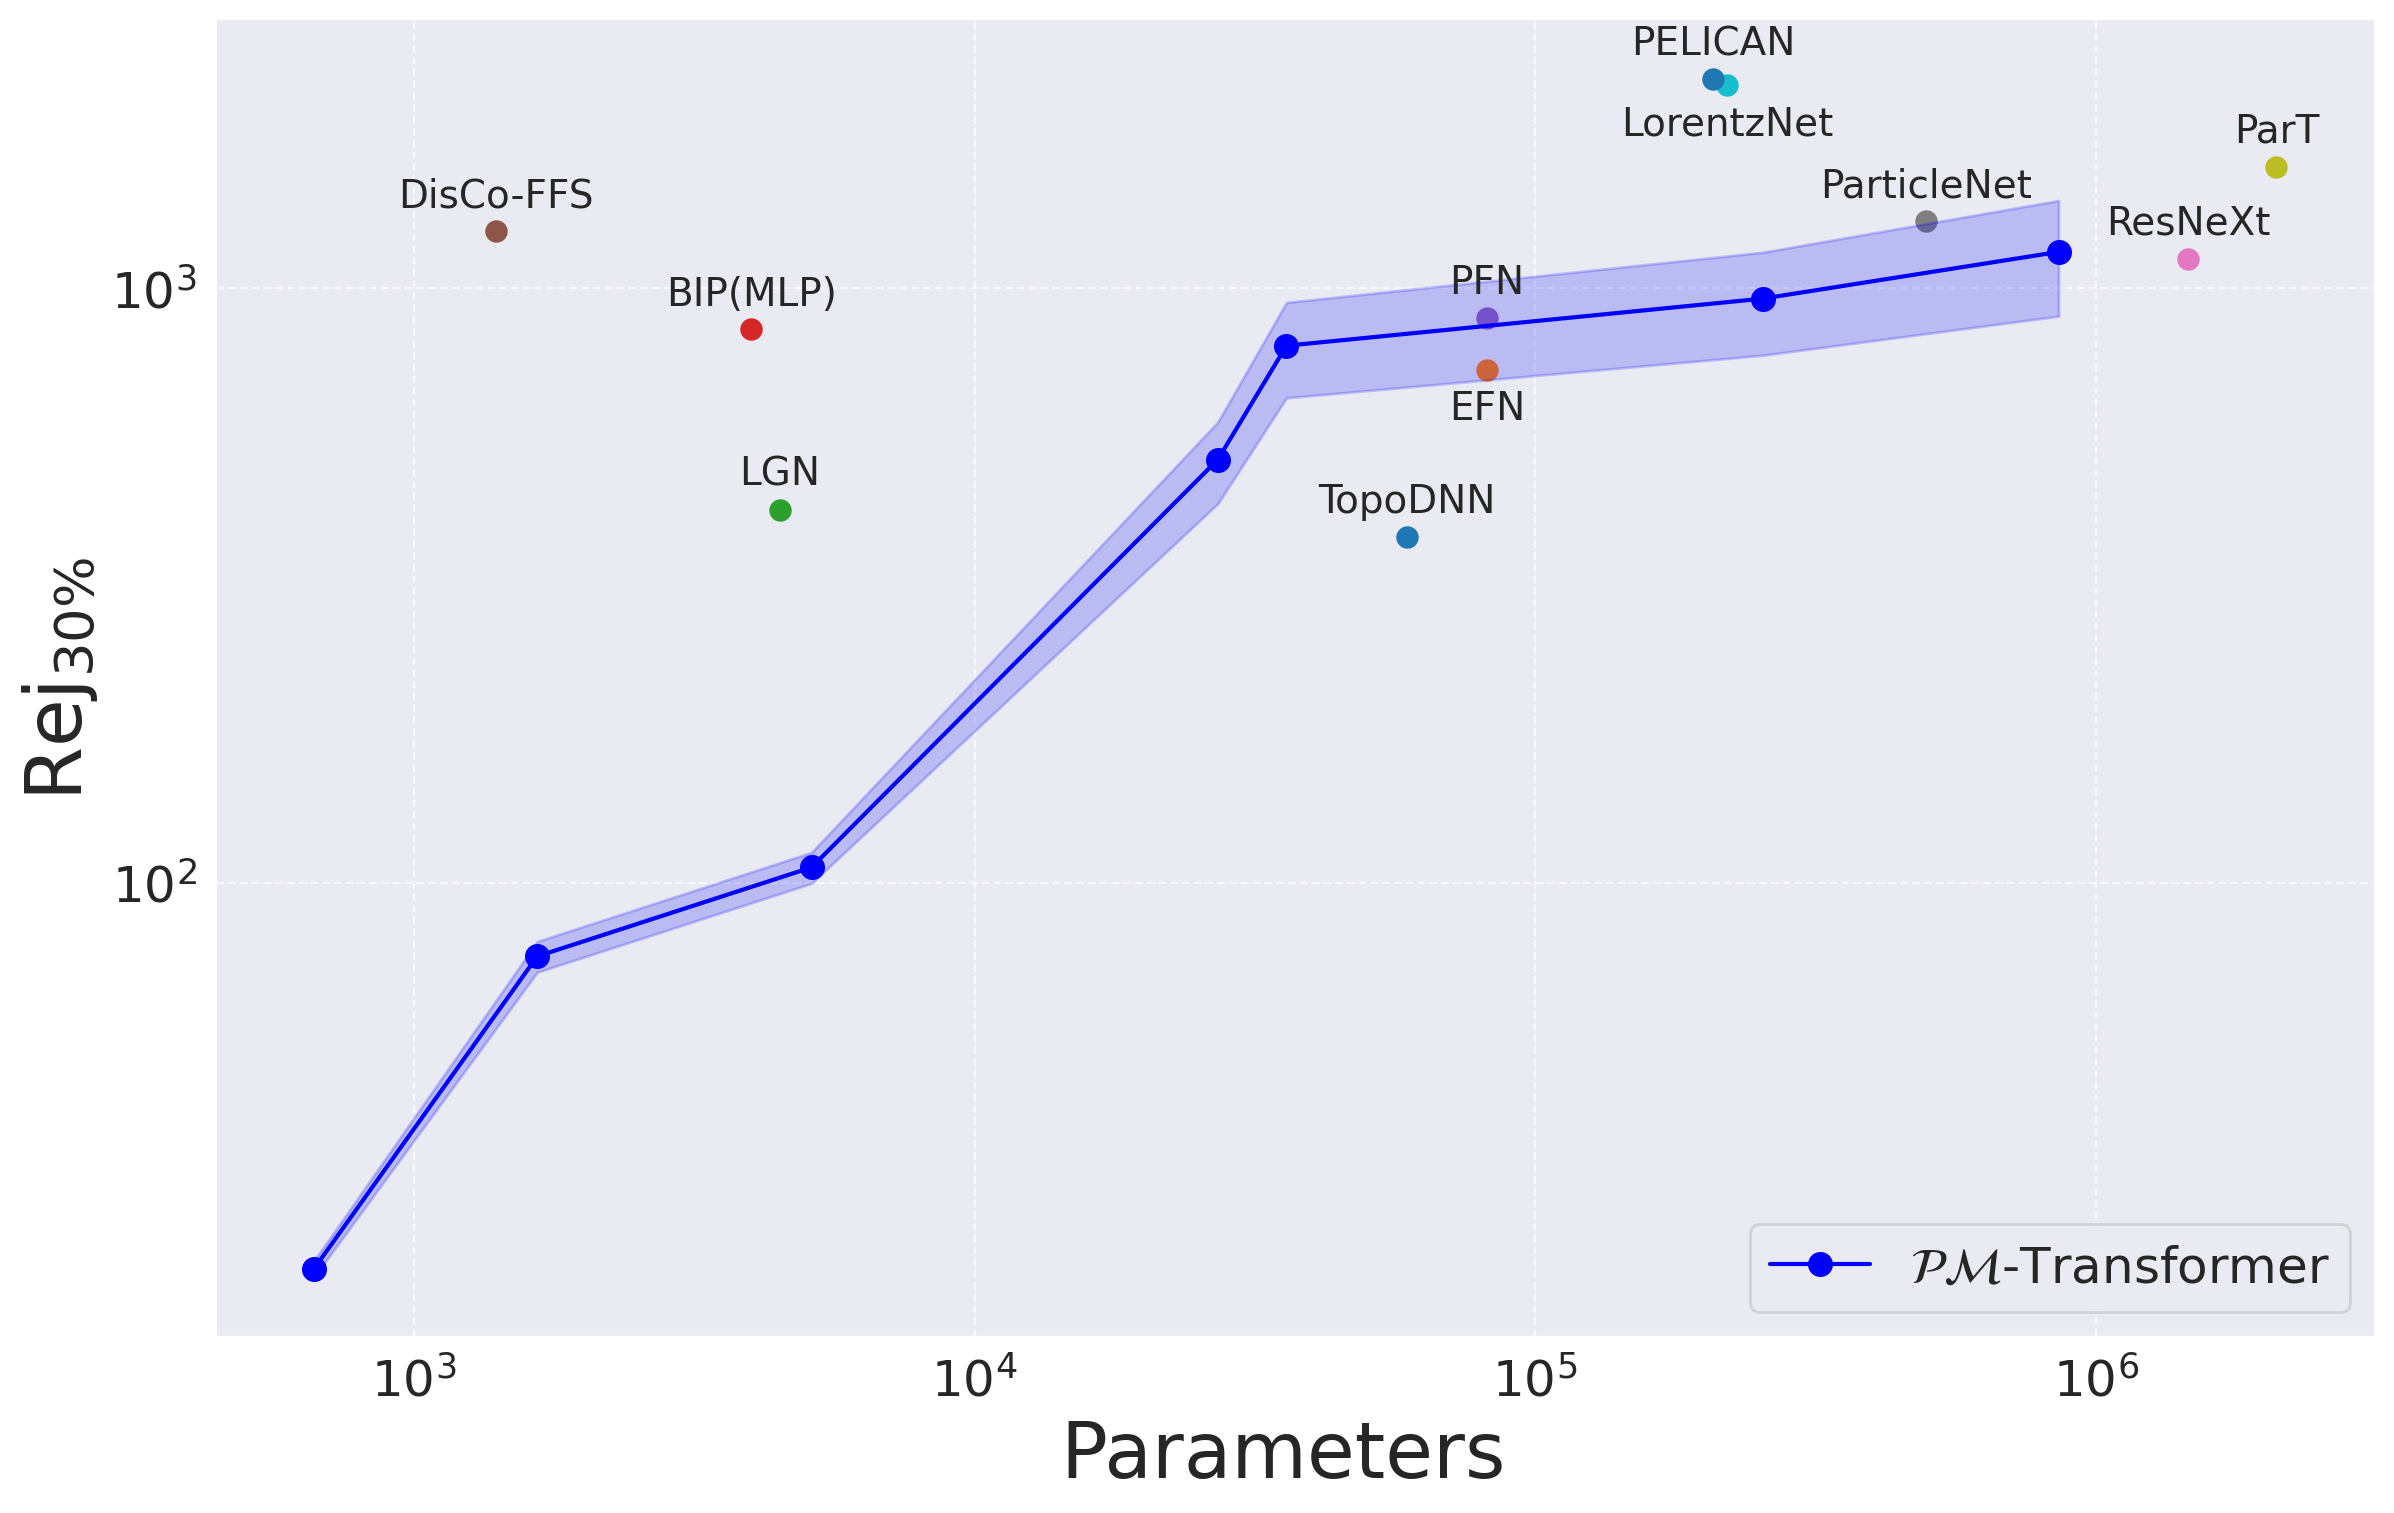

      params  overall_auc  accuracy_mean  overall_accuracy  accuracy_std  \
18     664.0     0.908910       0.861867          0.862156      0.001676   
10    1660.0     0.951785       0.899170          0.899128      0.001402   
9     5120.0     0.958407       0.903413          0.903520      0.001503   
5    27160.0     0.978248       0.926500          0.926507      0.001348   
7    36010.0     0.981249       0.930892          0.931064      0.001074   
19  254550.0     0.982586       0.934186          0.934178      0.001165   
28  858190.0     0.984272       0.937554          0.937700      0.001086   

    Top_rejection_50_mean  Top_rejection_50_std  Top_rejection_50_full  \
18              13.480469              0.291116              13.470812   
10              34.219623              1.336649              33.872505   
9               43.569433              1.742347              43.469107   
5              157.726561             12.725387             159.489731   
7              217.80

In [ ]:

# warnings.filterwarnings('ignore')
#

# Load the DataFrame
results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)

results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]

split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1,2,3,4,7,8]]
results_df[['particle_geom', 'particle_dim','jet_geom','jet_dim','layers','heads']] = split_columns
results_df['layers'] = results_df['layers'].str[-1]
results_df['heads'] = results_df['heads'].str.split('nheads').str[1]


param_map = {'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
  'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
  'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
  'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
  'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
  'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
  'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
  'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
  'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
  'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
  'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0} 

# Group by the columns and select the rows with the maximum 'overall_accuracy' for each group
best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)


result = best_rows_df.sort_values(by='params')[['params','overall_auc','accuracy_mean',
                                                'overall_accuracy','accuracy_std','Top_rejection_50_mean',
                                                'Top_rejection_50_std','Top_rejection_50_full','Top_rejection_30_full',
                                                'Top_rejection_30_mean','Top_rejection_30_std',
                                               'particle_geom', 'particle_dim','jet_geom','jet_dim','layers','heads']]
result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]
# result= result[(result['params'] != 83380.0)]


# plt.figure(figsize =(10,6))
# plt.title('Top Tagging Val Accuracy')
# plt.ylabel('Val Acc')
# plt.xlabel('Model Trainable Parameters')
# plt.plot(result['params'].to_numpy(),result['val_acc'].to_numpy())
# plt.xscale('log')
# # plt.ylim(0.92,0.95)

# # plt.xlim(2*1e4,2*1e6)
# plt.show()

# Manually input the data
data = {
    "Architecture": [
        "TopoDNN", "EFN", "LGN",  "BIP(MLP)", 
        "PFN", "DisCo-FFS", "ResNeXt", "ParticleNet", "ParT", 
        "LorentzNet", "PELICAN", 
    ],
    "Accuracy": [
        0.916, 0.927, 0.929,   0.931, 
        0.932, None, 0.936, 0.938, 0.940, 0.942, 
        0.9426, 0.9406
    ],
    "Params": [
        59000, 82000, 4500,  4000, 
        82000, 1400, 1460000, 498000, 2100000, 
        220000, 208000, 208000
    ],
    "rej_30": [
        382, 729, 424, 853, 
        891, 1249, 1122, 1298, 1602, 2195, 
        2250
    ]
}

# Create the plot
fig = plt.figure(figsize=(12, 8),dpi =200)
for i, architecture in enumerate(data["Architecture"]):
    x = data["Params"][i]  # Convert parameters to thousands
    y = data["rej_30"][i]
    if y is not None:  # Skip missing accuracies
        plt.scatter(x, y,s = 50)
        if 'Loren' in architecture or 'EFN' in architecture:
            plt.text(x, y*0.825, architecture, fontsize=14, ha='center')
        else:
            plt.text(x, y*1.1, architecture, fontsize=14, ha='center')

# Formatting
plt.xlabel("Parameters ", fontsize=28)
plt.ylabel(f"$\\text{{Rej}}_{{30\%}}$", fontsize=28)
plt.plot(result['params'].to_numpy(),result['Top_rejection_30_mean'].to_numpy(),label = f'$\mathcal{{P}}\mathcal{{M}}$-Transformer',color = 'b',marker='o', markersize = 8)
plt.fill_between(result['params'].to_numpy(), 
                             (result['Top_rejection_30_mean'].to_numpy() - result['Top_rejection_30_std'].to_numpy()),
                             (result['Top_rejection_30_mean'].to_numpy() + result['Top_rejection_30_std'].to_numpy()), 
                             color='blue', alpha=0.2)
# plt.title("Top Tagging: Rej (at 0.3) vs. Parameters", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.7)
plt.xscale('log')
plt.tight_layout()
plt.yscale('log')
plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
ax = plt.gca()


ax.tick_params(axis='x', which='major', labelsize=18)
ax.tick_params(axis='y', which='major', labelsize=18)
fig.patch.set_facecolor('white')
# Show the plot
plt.show()

print(result)

In [292]:
all_files = os.listdir()
gromov_output = []
for file in all_files: 
    if 'gromov' in file and 'csv' in file and 'bench' in file:
        gromov_output.append(file)

/tmp/ipykernel_629729/3483712952.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


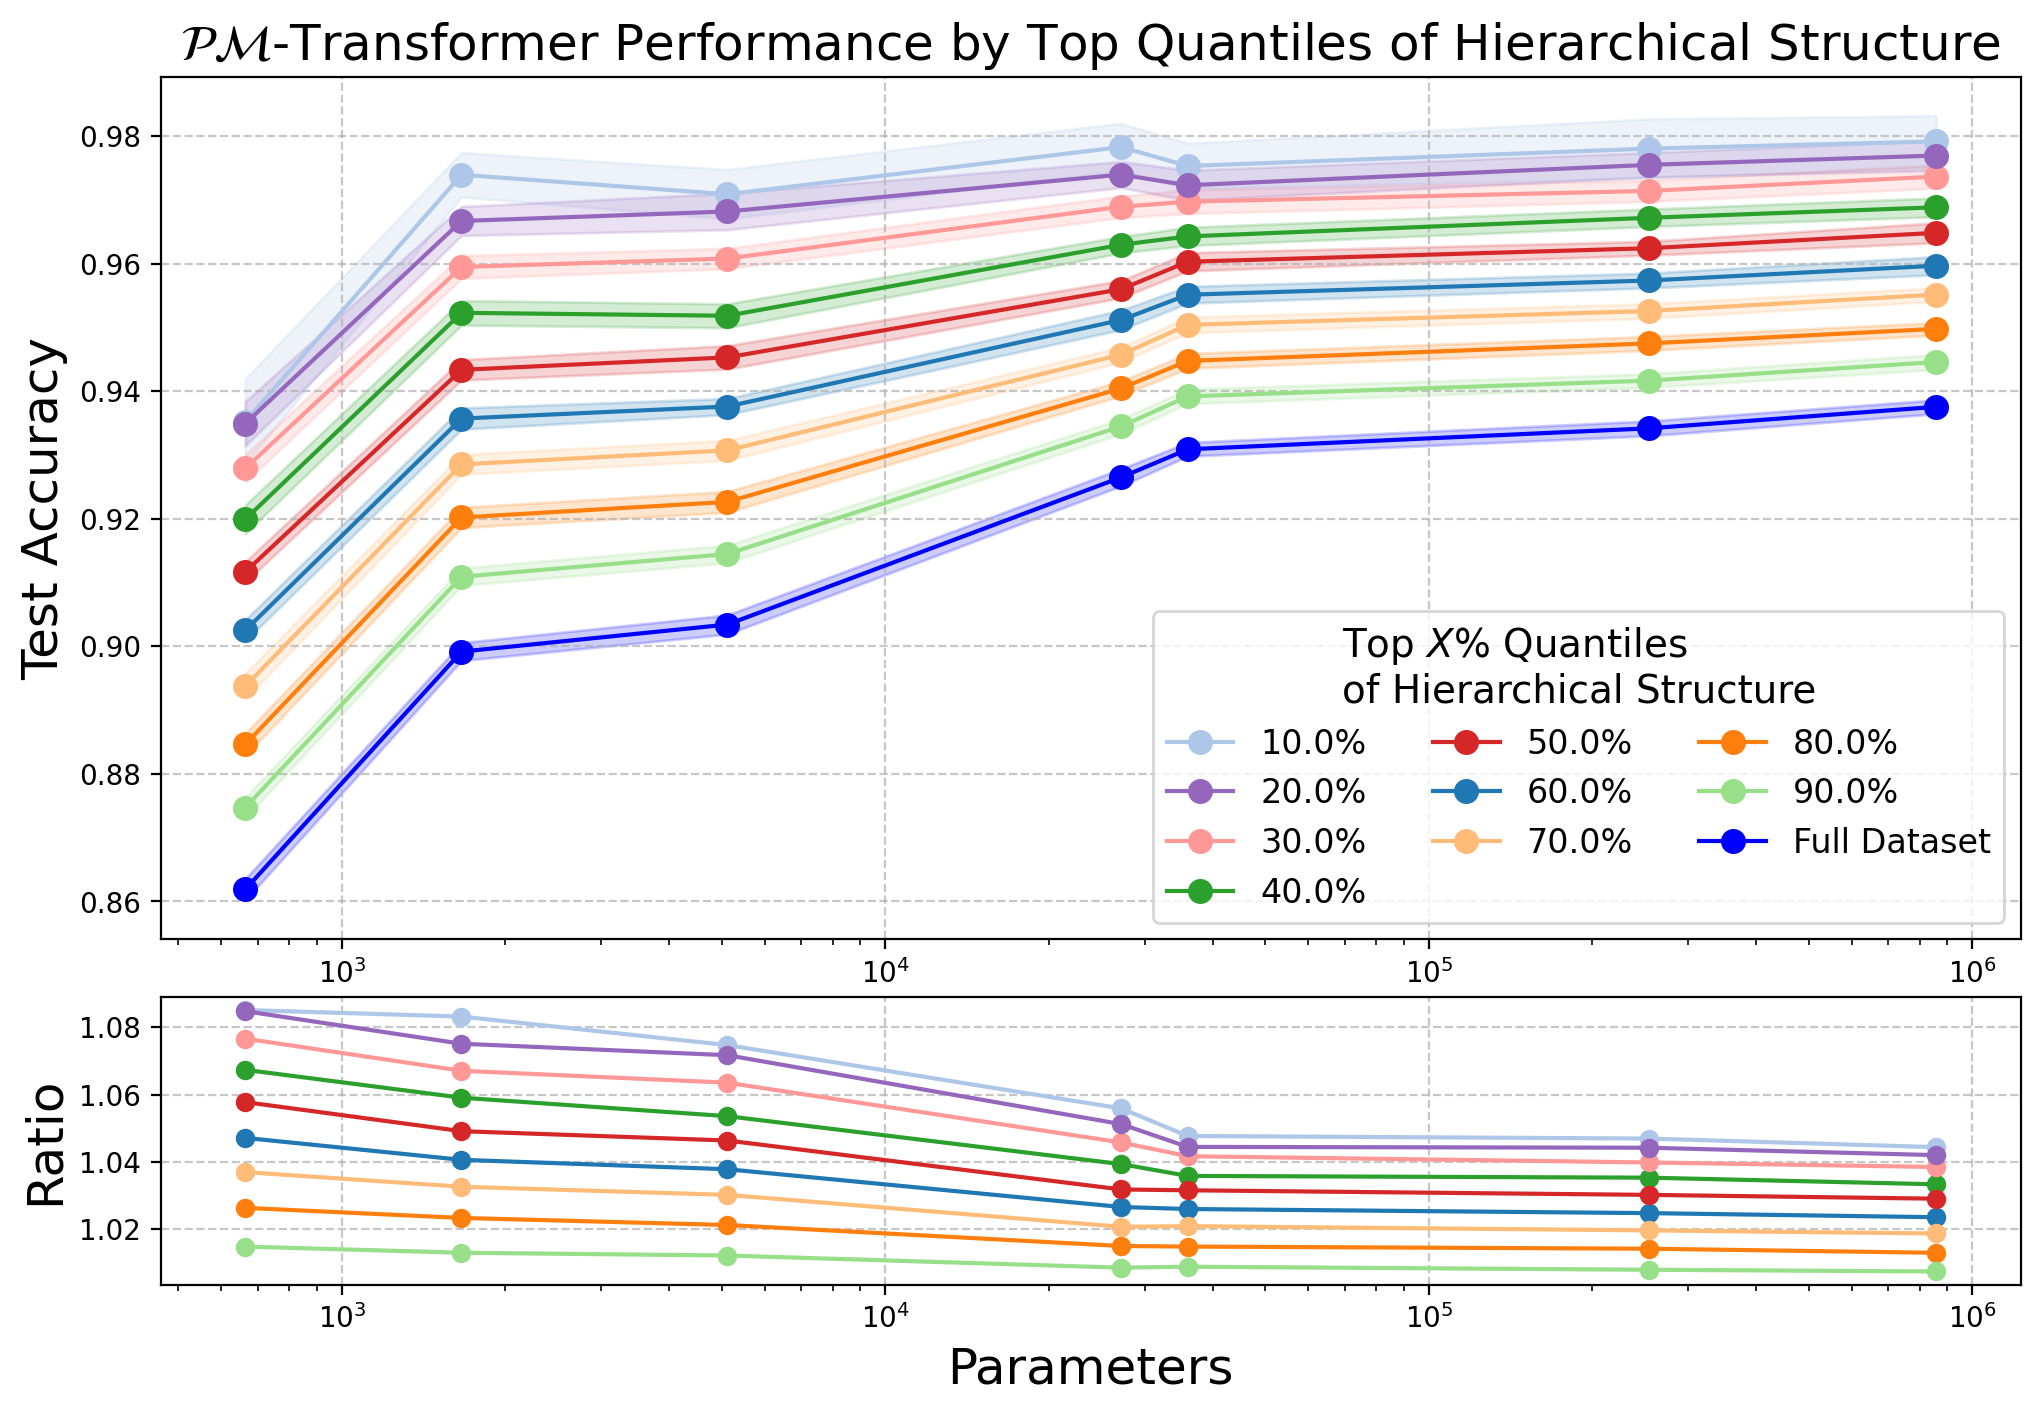

In [398]:
# Full code integrating split plot for ratio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


param_map = {
    'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
    'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
    'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
    'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
    'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
    'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
    'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
    'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
    'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
    'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
    'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0
}

# Define the figure and grid specification
fig = plt.figure(figsize=(12, 8), dpi=200)
gs = fig.add_gridspec(2, 1, height_ratios=[3,1], hspace=0.1)

# Main plot (accuracy vs. parameters)
ax1 = fig.add_subplot(gs[0])
cmap = plt.cm.get_cmap('tab20')
i = 0

# Iterate through gromov_output files
for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]


    label = f"{100 - cur_curv_percent}%"
    ax1.plot(result['params'], result['accuracy_mean'], label=label, color=cmap(i / 19), marker='o', markersize=8)
    ax1.fill_between(result['params'], 
                     result['accuracy_mean'] - result['accuracy_std'], 
                     result['accuracy_mean'] + result['accuracy_std'], 
                     color=cmap(i / 19), alpha=0.2)
    i += 1

# Full dataset plot
full_results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)
full_results_df['base_name'] = full_results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
split_columns = full_results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
full_results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
full_results_df['layers'] = full_results_df['layers'].str[-1]
full_results_df['heads'] = full_results_df['heads'].str.split('nheads').str[1]

best_full_rows_df = full_results_df.loc[full_results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_full_rows_df['params'] = best_full_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

full_result = best_full_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]

full_result= full_result[(full_result['params'] != 83380.0) & (full_result['params'] <= 1000000.0) & (full_result['params'] != 1490.0)]

ax1.plot(full_result['params'], full_result['accuracy_mean'], label='Full Dataset', color='b', marker='o', markersize=8)
ax1.fill_between(full_result['params'], 
                 full_result['accuracy_mean'] - full_result['accuracy_std'], 
                 full_result['accuracy_mean'] + full_result['accuracy_std'], 
                 color='b', alpha=0.2)

# Formatting for main plot
ax1.set_xscale('log')
ax1.set_ylabel("Test Accuracy", fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()

# Define a sorting key
def sorting_key(hl):
    handle, label = hl
    try:
        return (0, int(label))  # Sort numeric labels by their value
    except ValueError:
        return (1, label)       # Non-numeric labels go to the bottom

# Sort handles and labels
sorted_handles_labels = sorted(zip(handles, labels), key=sorting_key)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add sorted legend
plt.legend(sorted_handles, sorted_labels, ncol=3, 
           fontsize=12, loc='lower right',
           title = f'Top $X$% Quantiles \nof Hierarchical Structure',
           title_fontsize = 14)


# plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
plt.title(
    r'$\mathcal{P}\mathcal{M}$-Transformer Performance by Top Quantiles of Hierarchical Structure',
    fontsize=18,  # Adjust fontsize as needed
    wrap=True     # Optional: enables auto-wrapping for long titles
)
ax1.grid(True, linestyle="--", alpha=0.7)



# Ratio plot (below the main plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Reset color iterator for consistent colors in lower plot
i = 0

for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params','auc_mean','auc_std', 'accuracy_mean', 'accuracy_std','Top_rejection_30_mean','Top_rejection_30_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]

    
    # Compute the ratio
    try:
        ratio = result['accuracy_mean'] / np.interp(result['params'], full_result['params'], full_result['accuracy_mean'])
    except Exception as e:
        print(f"Error computing ratio for {file}: {e}")
        continue

    # Plot the ratio
    ax2.plot(result['params'], ratio, label=f"{100 - cur_curv_percent}%", color=cmap(i / 19), marker='o', markersize=6)
    i += 1
#     print(f'{100 - cur_curv_percent}')
#     print(result)

# Formatting for ratio plot
ax2.set_xscale('log')
ax2.set_xlabel("Parameters", fontsize=18)
ax2.set_ylabel("Ratio", fontsize=18)
ax2.grid(True, linestyle="--", alpha=0.7)

# Set figure background
fig.patch.set_facecolor('white')

# Show the plot
plt.show()


/tmp/ipykernel_629729/4034895078.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


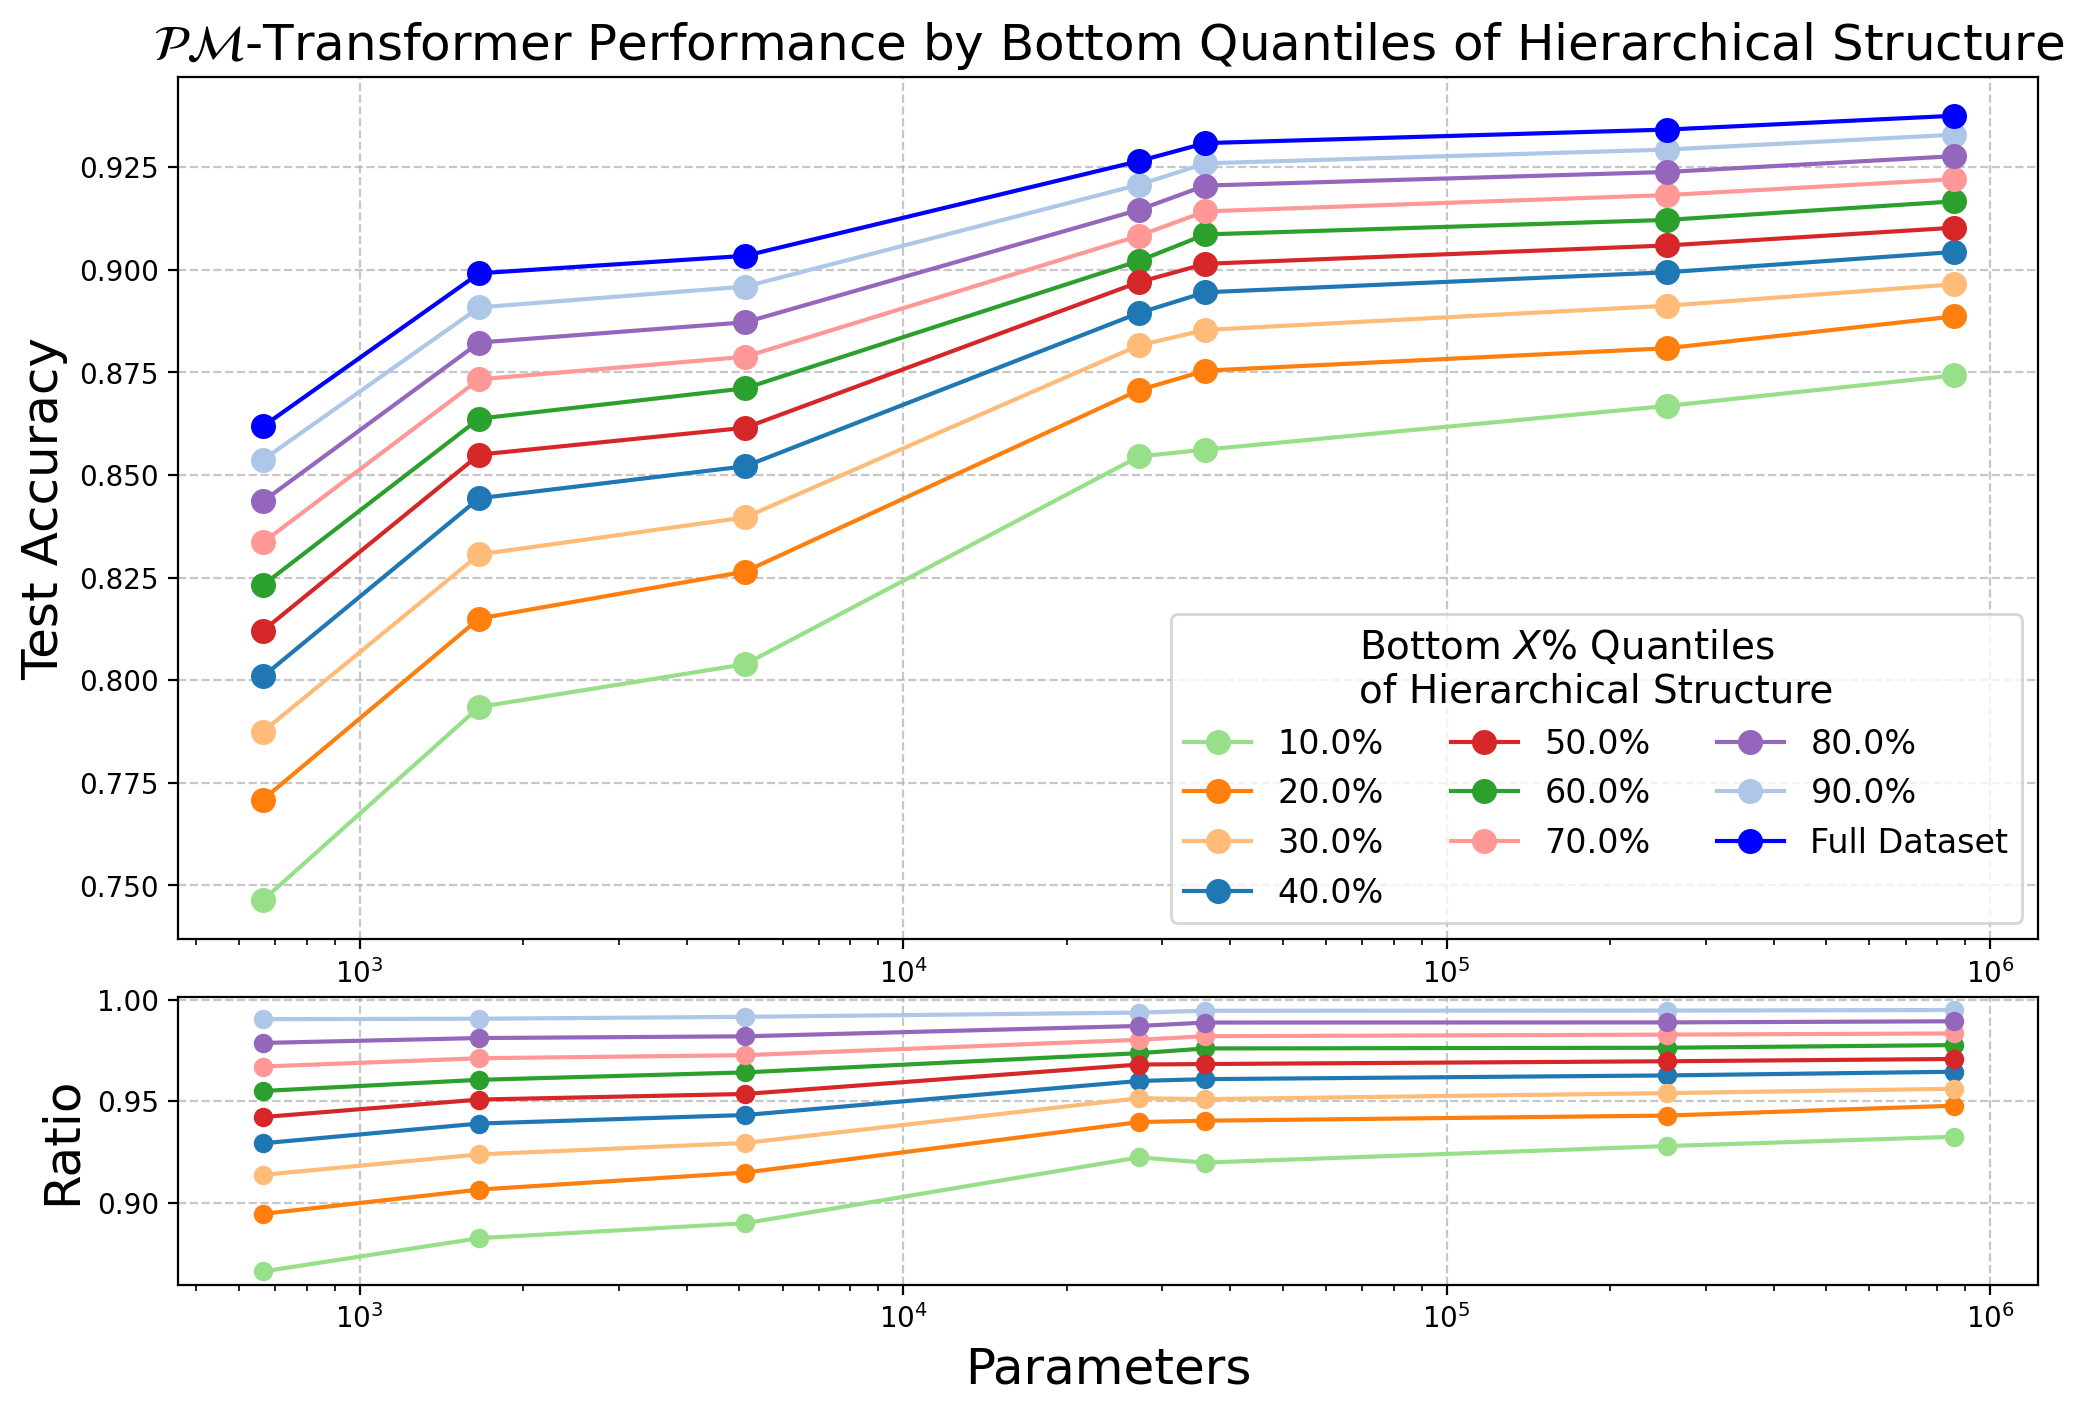

In [400]:
# Full code integrating split plot for ratio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


param_map = {
    'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
    'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
    'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
    'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
    'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
    'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
    'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
    'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
    'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
    'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
    'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0
}

# Define the figure and grid specification
fig = plt.figure(figsize=(12, 8), dpi=200)
gs = fig.add_gridspec(2, 1, height_ratios=[3,1], hspace=0.1)

# Main plot (accuracy vs. parameters)
ax1 = fig.add_subplot(gs[0])
cmap = plt.cm.get_cmap('tab20')
i = 0

# Iterate through gromov_output files
for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]


    label = f"{cur_curv_percent}%"
    top_n = 100 - cur_curv_percent
    acc_on_removed= (full_result['accuracy_mean'].to_numpy() -result['accuracy_mean'].to_numpy()*((top_n)/100))/((100-top_n)/100)
    
    
    ax1.plot(result['params'], acc_on_removed, label=label, color=cmap(i / 19), marker='o', markersize=8)
    i += 1

# Full dataset plot
full_results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)
full_results_df['base_name'] = full_results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
split_columns = full_results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
full_results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
full_results_df['layers'] = full_results_df['layers'].str[-1]
full_results_df['heads'] = full_results_df['heads'].str.split('nheads').str[1]

best_full_rows_df = full_results_df.loc[full_results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_full_rows_df['params'] = best_full_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

full_result = best_full_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]

full_result= full_result[(full_result['params'] != 83380.0) & (full_result['params'] <= 1000000.0) & (full_result['params'] != 1490.0)]

ax1.plot(full_result['params'], full_result['accuracy_mean'], label='Full Dataset', color='b', marker='o', markersize=8)


# Formatting for main plot
ax1.set_xscale('log')
ax1.set_ylabel("Test Accuracy", fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()

# Define a sorting key
def sorting_key(hl):
    handle, label = hl
    try:
        return (0, int(label))  # Sort numeric labels by their value
    except ValueError:
        return (1, label)       # Non-numeric labels go to the bottom

# Sort handles and labels
sorted_handles_labels = sorted(zip(handles, labels), key=sorting_key)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add sorted legend
plt.legend(sorted_handles, sorted_labels, ncol=3, 
           fontsize=12, loc='lower right',
           title = f'Bottom $X$% Quantiles \nof Hierarchical Structure',
           title_fontsize = 14)


# plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
plt.title(
    r'$\mathcal{P}\mathcal{M}$-Transformer Performance by Bottom Quantiles of Hierarchical Structure',
    fontsize=18,  # Adjust fontsize as needed
    wrap=True     # Optional: enables auto-wrapping for long titles
)
ax1.grid(True, linestyle="--", alpha=0.7)



# Ratio plot (below the main plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Reset color iterator for consistent colors in lower plot
i = 0

for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 95 or cur_curv_percent % 10 != 0:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params','auc_mean','auc_std', 'accuracy_mean', 'accuracy_std','Top_rejection_30_mean','Top_rejection_30_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]
    
    top_n = 100 - cur_curv_percent
    acc_on_removed= (full_result['accuracy_mean'].to_numpy() -result['accuracy_mean'].to_numpy()*((top_n)/100))/((100-top_n)/100)
    # Compute the ratio
    try:
        ratio = acc_on_removed / np.interp(result['params'], full_result['params'], full_result['accuracy_mean'])
    except Exception as e:
        print(f"Error computing ratio for {file}: {e}")
        continue

    # Plot the ratio
    ax2.plot(result['params'], ratio, label=f"{cur_curv_percent}%", color=cmap(i / 19), marker='o', markersize=6)
    i += 1
#     print(f'{100 - cur_curv_percent}')
#     print(result)

# Formatting for ratio plot
ax2.set_xscale('log')
ax2.set_xlabel("Parameters", fontsize=18)
ax2.set_ylabel("Ratio", fontsize=18)
ax2.grid(True, linestyle="--", alpha=0.7)

# Set figure background
fig.patch.set_facecolor('white')

# Show the plot
plt.show()


/tmp/ipykernel_629729/2472314816.py:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


97.0
      params  auc_mean   auc_std  accuracy_mean  accuracy_std  \
18     664.0  0.876483  0.001365       0.866849      0.001531   
10    1660.0  0.906919  0.001155       0.903474      0.001205   
9     5120.0  0.909577  0.001405       0.907227      0.001400   
5    27160.0  0.929685  0.001284       0.929397      0.001305   
7    36010.0  0.934008  0.001037       0.933989      0.001040   
19  254550.0  0.937273  0.001137       0.936862      0.001142   
28  858190.0  0.940763  0.001113       0.940440      0.001128   

    Top_rejection_30_mean  Top_rejection_30_std  
18              23.661814              0.721981  
10              75.890995              4.942684  
9              110.271128              7.303658  
5              565.058184             99.966163  
7              802.117574            146.559315  
19            1004.550330            207.633975  
28            1243.497155            237.555499  
96.0
      params  auc_mean   auc_std  accuracy_mean  accuracy_std  \
18  

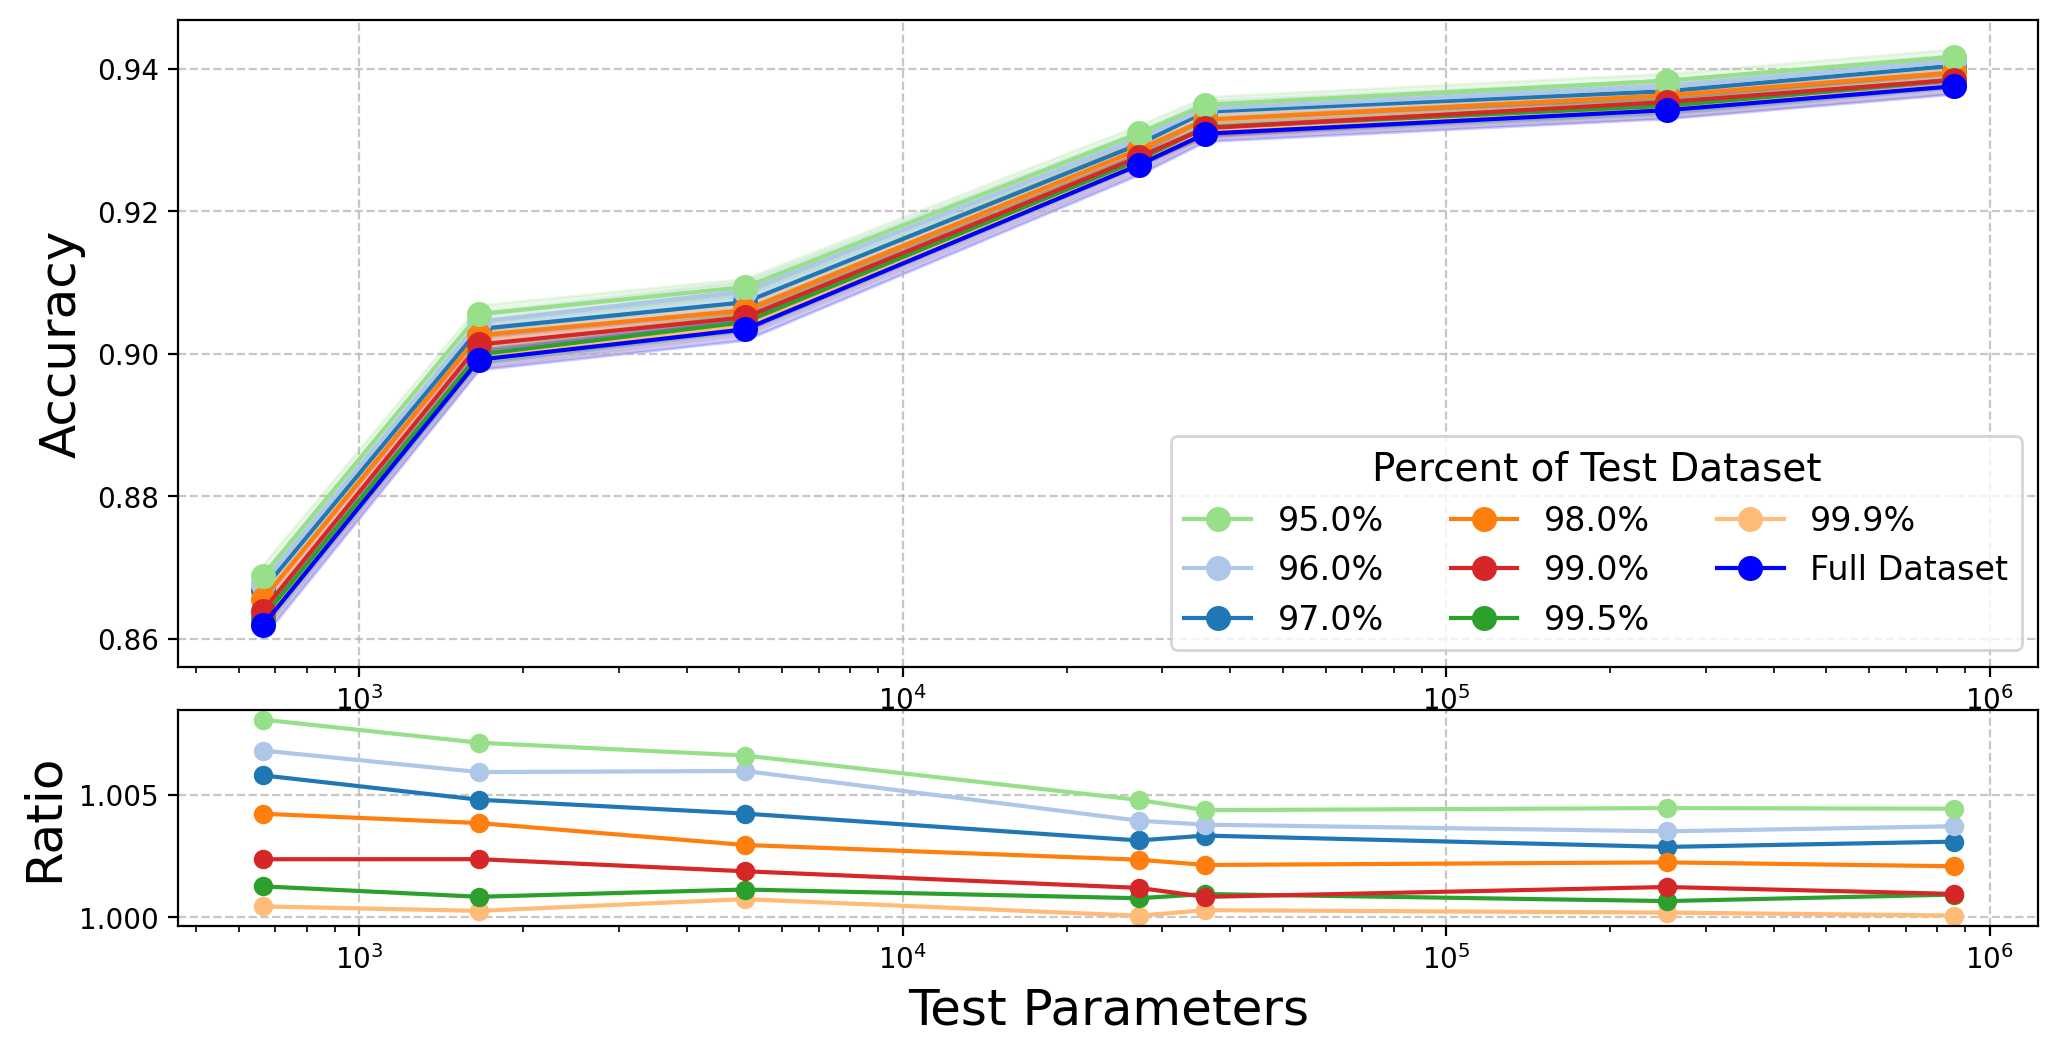

In [328]:
# Full code integrating split plot for ratio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


param_map = {
    'RxH_2_RxH_2_partD4_jetD4_layers1_nheads1': 664.0,
    'RxH_120_RxH_128_partD240_jetD256_layers4_nheads12': 1380000.0,
    'RxH_2_RxH_6_partD4_jetD12_layers2_nheads1': 1490.0,
    'RxH_4_RxH_4_partD8_jetD8_layers1_nheads1': 1660.0,
    'RxH_5_RxH_12_partD10_jetD24_layers2_nheads1': 5120.0,
    'RxH_120_RxH_128_partD240_jetD256_layers8_nheads12': 2029999.9999999998,
    'RxH_40_RxH_48_partD80_jetD96_layers8_nheads4': 254550.0,
    'RxH_10_RxH_24_partD20_jetD48_layers2_nheads1': 27160.0,
    'RxH_10_RxH_24_partD20_jetD48_layers8_nheads1': 36010.0,
    'RxH_20_RxH_32_partD40_jetD64_layers8_nheads2': 83380.0,
    'RxH_80_RxH_64_partD160_jetD128_layers8_nheads8': 858190.0
}

# Define the figure and grid specification
fig = plt.figure(figsize=(12, 6), dpi=200)
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.1)

# Main plot (accuracy vs. parameters)
ax1 = fig.add_subplot(gs[0])
cmap = plt.cm.get_cmap('tab20')
i = 0

# Iterate through gromov_output files
for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 9:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params','auc_mean','auc_std', 'accuracy_mean', 'accuracy_std','Top_rejection_30_mean','Top_rejection_30_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]


    label = f"{100 - cur_curv_percent}%"
    ax1.plot(result['params'], result['accuracy_mean'], label=label, color=cmap(i / 19), marker='o', markersize=8)
    ax1.fill_between(result['params'], 
                     result['accuracy_mean'] - result['accuracy_std'], 
                     result['accuracy_mean'] + result['accuracy_std'], 
                     color=cmap(i / 19), alpha=0.2)
    acc = result['accuracy_mean']
    print(f'{100 - cur_curv_percent}')
    print(result)
    i += 1

# Full dataset plot
full_results_df = pd.read_csv('top_PMTrans_benchmark.csv').sort_values('overall_accuracy', ascending=False)
full_results_df['base_name'] = full_results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
split_columns = full_results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
full_results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
full_results_df['layers'] = full_results_df['layers'].str[-1]
full_results_df['heads'] = full_results_df['heads'].str.split('nheads').str[1]

best_full_rows_df = full_results_df.loc[full_results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
best_full_rows_df['params'] = best_full_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

full_result = best_full_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]

full_result= full_result[(full_result['params'] != 83380.0) & (full_result['params'] <= 1000000.0) & (full_result['params'] != 1490.0)]

ax1.plot(full_result['params'], full_result['accuracy_mean'], label='Full Dataset', color='b', marker='o', markersize=8)
ax1.fill_between(full_result['params'], 
                 full_result['accuracy_mean'] - full_result['accuracy_std'], 
                 full_result['accuracy_mean'] + full_result['accuracy_std'], 
                 color='b', alpha=0.2)

# Formatting for main plot
ax1.set_xscale('log')
ax1.set_ylabel("Accuracy", fontsize=18)
handles, labels = plt.gca().get_legend_handles_labels()

# Define a sorting key
def sorting_key(hl):
    handle, label = hl
    try:
        return (0, int(label))  # Sort numeric labels by their value
    except ValueError:
        return (1, label)       # Non-numeric labels go to the bottom

# Sort handles and labels
sorted_handles_labels = sorted(zip(handles, labels), key=sorting_key)
sorted_handles, sorted_labels = zip(*sorted_handles_labels)

# Add sorted legend
plt.legend(sorted_handles, sorted_labels, ncol=3, 
           fontsize=12, loc='lower right',
           title = 'Percent of Test Dataset',
           title_fontsize = 14)


# plt.legend(ncol = 1,fontsize = 18,loc = 'lower right')
# plt.title(
#     r'Performance of $\mathcal{P}\mathcal{M}$-Transformer on Hyperbolicity Filtered Test Dataset',
#     fontsize=18,  # Adjust fontsize as needed
#     wrap=True     # Optional: enables auto-wrapping for long titles
# )
ax1.grid(True, linestyle="--", alpha=0.7)



# Ratio plot (below the main plot)
ax2 = fig.add_subplot(gs[1], sharex=ax1)

# Reset color iterator for consistent colors in lower plot
i = 0

for file in gromov_output:
    if 'False' in file:
        continue

    cur_curv_percent = float(file.split('_')[-3])
    if cur_curv_percent > 9:
        continue

    results_df = pd.read_csv(file).sort_values('overall_accuracy', ascending=False)
    results_df['base_name'] = results_df['model_id'].str.split('batch128').str[1].str.split('_redo').str[0]
    split_columns = results_df['base_name'].str.split('_final', expand=True)[0].str.split('_', expand=True).iloc[:, [1, 2, 3, 4, 7, 8]]
    results_df[['particle_geom', 'particle_dim', 'jet_geom', 'jet_dim', 'layers', 'heads']] = split_columns
    results_df['layers'] = results_df['layers'].str[-1]
    results_df['heads'] = results_df['heads'].str.split('nheads').str[1]

    best_rows_df = results_df.loc[results_df.groupby(['base_name'])['overall_accuracy'].idxmax()]
    best_rows_df['params'] = best_rows_df['base_name'].str.split('PMTrans_').str[1].map(param_map)

    result = best_rows_df.sort_values(by='params')[['params', 'accuracy_mean', 'accuracy_std']]
    result= result[(result['params'] != 83380.0) & (result['params'] <= 1000000.0) & (result['params'] != 1490.0)]



    # Compute the ratio
    try:
        ratio = result['accuracy_mean'] / np.interp(result['params'], full_result['params'], full_result['accuracy_mean'])
    except Exception as e:
        print(f"Error computing ratio for {file}: {e}")
        continue

    # Plot the ratio
    ax2.plot(result['params'], ratio, label=f"{100 - cur_curv_percent}%", color=cmap(i / 19), marker='o', markersize=6)
    i += 1

# Formatting for ratio plot
ax2.set_xscale('log')
ax2.set_xlabel("Test Parameters", fontsize=18)
ax2.set_ylabel("Ratio", fontsize=18)
ax2.grid(True, linestyle="--", alpha=0.7)


# Set figure background
fig.patch.set_facecolor('white')

# Show the plot
plt.show()
